In [1]:
!pip data.shapeinstall -q tensorflow-text

ERROR: unknown command "data.shapeinstall"


In [2]:
!pip install -q tf-models-official

In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("/content/drive/MyDrive/IMDB Dataset.csv")

In [5]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
print(df.shape)

(50000, 2)


In [7]:
print(df.isnull().sum())

review       0
sentiment    0
dtype: int64


In [8]:
labeling = {
    'positive':1,
    'negative':0
}

df['sentiment'] = df['sentiment'].apply(lambda x : labeling[x])

In [9]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


<Axes: xlabel='sentiment'>

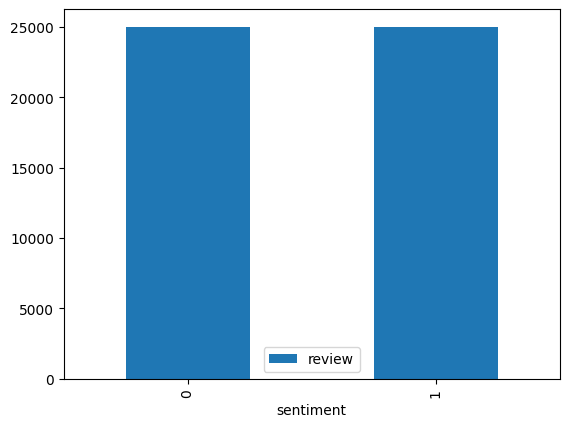

In [10]:
df.groupby('sentiment').count().plot(kind='bar')

In [11]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'

tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [12]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [13]:
text_test = ['this is such an amazing movie','nice movie indeed']
text_preprocessed = bert_preprocess_model(text_test)

In [14]:
# "input_word_ids": has the token ids of the input sequences.
# "input_mask": has value 1 at the position of all input tokens present before padding and value 0 for the padding tokens.
# "input_type_ids": has the index of the input segment that gave rise to the input token at the respective position. The first input segment (index 0) includes the start-of-sequence token and its end-of-segment token. The second segment (index 1, if present) includes its end-of-segment token. Padding tokens get index 0 again.
# The encoder's outputs are the pooled_output to represents each input sequence as a whole, and the sequence_output to represent each input token in context. Either of those can be used as input to further model building.

In [15]:
#CLS and SEP tokens are added at start and end of the strings respectively so the length increases by 2
#CLS is classification and SEP is seperator
print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][1, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][1, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][1, :12]}')

Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (2, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  102    0    0    0    0]
Word Ids   : [ 101 3835 3185 5262  102    0    0    0    0    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 0 0 0 0]
Input Mask : [1 1 1 1 1 0 0 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [16]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [17]:
bert_results = bert_model(text_preprocessed)

In [18]:
print(bert_results.keys())

dict_keys(['encoder_outputs', 'pooled_output', 'sequence_output', 'default'])


In [19]:
(bert_results['pooled_output']) #encoding of a sentence

<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[ 0.9462299 ,  0.9697841 ,  0.13774446, ...,  0.09079167,
        -0.38429034,  0.18916361],
       [ 0.827148  ,  0.96872866,  0.1140682 , ...,  0.51650274,
        -0.38488477, -0.69762874]], dtype=float32)>

In [20]:
(bert_results['sequence_output']) #encoding of each token of each sentence

<tf.Tensor: shape=(2, 128, 512), dtype=float32, numpy=
array([[[-0.3462882 ,  0.2521057 ,  0.575659  , ..., -0.15549664,
          0.47201574,  0.37473986],
        [-0.5864682 ,  0.31059277, -0.27019376, ...,  0.5594985 ,
         -0.23402545,  0.9216209 ],
        [-0.8776431 ,  0.43894875, -0.6175933 , ...,  0.04506303,
         -0.3496607 ,  0.4384323 ],
        ...,
        [-0.29515886, -0.20628786, -0.25817713, ...,  0.5091484 ,
          0.5348349 ,  0.71445304],
        [-0.88576245, -0.63577425, -0.5987598 , ...,  0.2214176 ,
         -0.126766  ,  1.1186132 ],
        [-1.1359333 , -0.95454174,  0.0908939 , ...,  0.33418873,
          0.27720279,  1.113666  ]],

       [[ 0.3405885 , -0.139061  ,  0.7246336 , ..., -0.27519035,
          2.2812626 ,  0.52038574],
        [ 0.5705015 ,  0.34697884,  0.13037366, ..., -0.78712887,
          0.8287317 ,  0.15868463],
        [ 0.26413733,  0.7609923 ,  0.01988198, ...,  0.35271662,
          1.5018486 ,  0.0042081 ],
        ...,

In [21]:
len(bert_results['encoder_outputs']) #The length is 4 because we are using the BERT version in which 4 encoders are stacked
#It gives the output of each encoder

4

In [22]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [23]:
classifier_model = build_classifier_model()

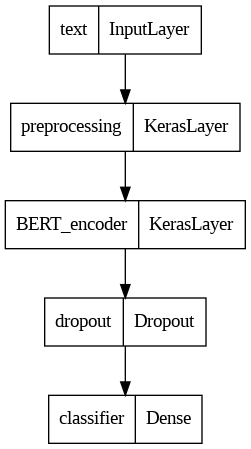

In [24]:
tf.keras.utils.plot_model(classifier_model)

In [25]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [26]:
epochs = 5
steps_per_epoch = 625
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [27]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [28]:
X = df['review']
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.review,df.sentiment, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.16, random_state=1)

print('Number of reviews in the total set : {}'.format(len(X)))
print('Number of reviews in the training set : {}'.format(len(X_train)))
print('Number of reviews in the validation set : {}'.format(len(X_val)))
print('Number of reviews in the testing set : {}'.format(len(X_test)))

Number of reviews in the total set : 50000
Number of reviews in the training set : 33600
Number of reviews in the validation set : 6400
Number of reviews in the testing set : 10000


In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(X_train, y_train,
                               validation_data=(X_val, y_val),
                               epochs=epochs)

In [29]:
model_path = '/content/drive/MyDrive/BERT Model/'
loaded_model = tf.saved_model.load(model_path)

In [ ]:
loss, accuracy = loaded_model.evaluate(X_test, y_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

In [30]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',
    'The movie was great!',
    'The movie was meh.',
    'The movie was idiotic.',
    'The movie was terrible...'
]

original_results = tf.sigmoid(loaded_model(tf.constant(examples)))

print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the model in memory:
input: this is such an amazing movie! : score: 0.997652
input: The movie was great!           : score: 0.987674
input: The movie was meh.             : score: 0.438580
input: The movie was idiotic.         : score: 0.002172
input: The movie was terrible...      : score: 0.001972

